In [380]:
import pysrt
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import json
stop_fr = pd.read_json("stop_words_french.json")
verbes = pd.read_csv("verbes.csv", encoding='utf-8')["Verbes"].to_list()

import spacy
nlp = spacy.load('fr_core_news_md')

In [381]:
from pprint import pprint 

from pythonopensubtitles.opensubtitles import OpenSubtitles
from pythonopensubtitles.utils import File

In [382]:
ost = OpenSubtitles() 
ost.login('guillaume.grelet+ost@gmail.com', 'Relish-Hatching-Ocean7-Tripod-Detention')

'DZVAIirEJNjn9NZY-P1hHl7w4Y5'

In [383]:
movie_name = "La Vérité Si Je Mens"

In [384]:
query = ost.search_subtitles([{"query": movie_name, "sublanguageid": "fre"}])[1]
id_subtitle_file = query["IDSubtitleFile"]
sub_file_name = query["SubFileName"]
print(sub_file_name)

La Vérité Si Je Mens 2 - 1080p FR x264 ac3.srt


In [385]:
ost.download_subtitles(
    ids=[id_subtitle_file],
    override_filenames={id_subtitle_file: sub_file_name},
    extension='srt',
    encoding=query["SubEncoding"],
)

{'1956834997': './La Vérité Si Je Mens 2 - 1080p FR x264 ac3.srt'}

In [386]:
subs = pysrt.open(sub_file_name)

In [387]:
subs_text = []
for sub in subs:
    subs_text.append(sub.text)

In [388]:
subtitles = pd.DataFrame()
subtitles["text"] = subs_text
subtitles["text"] = subtitles["text"].fillna("")

In [389]:
subtitles["text"]  = subtitles["text"].apply(lambda x:re.sub(r'[^\w\s]', ' ', x))

In [390]:
words_list = [rev for rev in subtitles["text"].apply(lambda x:x.split(' '))]
words_i = [list(range(len(rev))) for rev in subtitles["text"].apply(lambda x:x.split(' '))]


In [391]:
flat_words_list = [item for sublist in words_list for item in sublist]
flat_words_i = [item for sublist in words_i for item in sublist]


In [392]:
df_words = pd.DataFrame()
df_words["words"] = flat_words_list
df_words["indice"] = flat_words_i


In [393]:
len(df_words)

13856

In [394]:
df_words = df_words[df_words["words"].apply(len)>0]

In [395]:
df_words["nom_propre"] = 1*(df_words["words"].apply(lambda x:x[0].isupper()))*(df_words["indice"]!=0)

In [396]:
df_words["words"] = df_words["words"].apply(lambda x:x.lower())

In [397]:
nom_propres = df_words[df_words["nom_propre"]==1][["words","nom_propre"]]

In [398]:
df_words = df_words.drop("nom_propre",axis=1)

In [399]:

df_words = df_words.merge(nom_propres.drop_duplicates("words"),on="words",how='left')

df_words["nom_propre"] = df_words["nom_propre"].fillna(0)

In [400]:
len(df_words)

9591

In [401]:
df_words_lemma = df_words[df_words["nom_propre"]==0].drop_duplicates("words")

In [402]:
df_words_lemma["lemma"] = df_words_lemma["words"].apply(lambda x:nlp(x)[0].lemma_)

In [403]:
df_words = df_words.merge(df_words_lemma[["words","lemma"]],
               on = "words",
               how = "left")

In [404]:
df_words["lemma"] = df_words["lemma"].fillna(df_words["words"])

In [405]:
df_words["lemma"] = df_words["lemma"].apply(lambda x:x.replace(" ",""))

In [406]:
stop_words = stop_fr[0].to_list() + list(STOPWORDS) + verbes + ["oui","allez"]

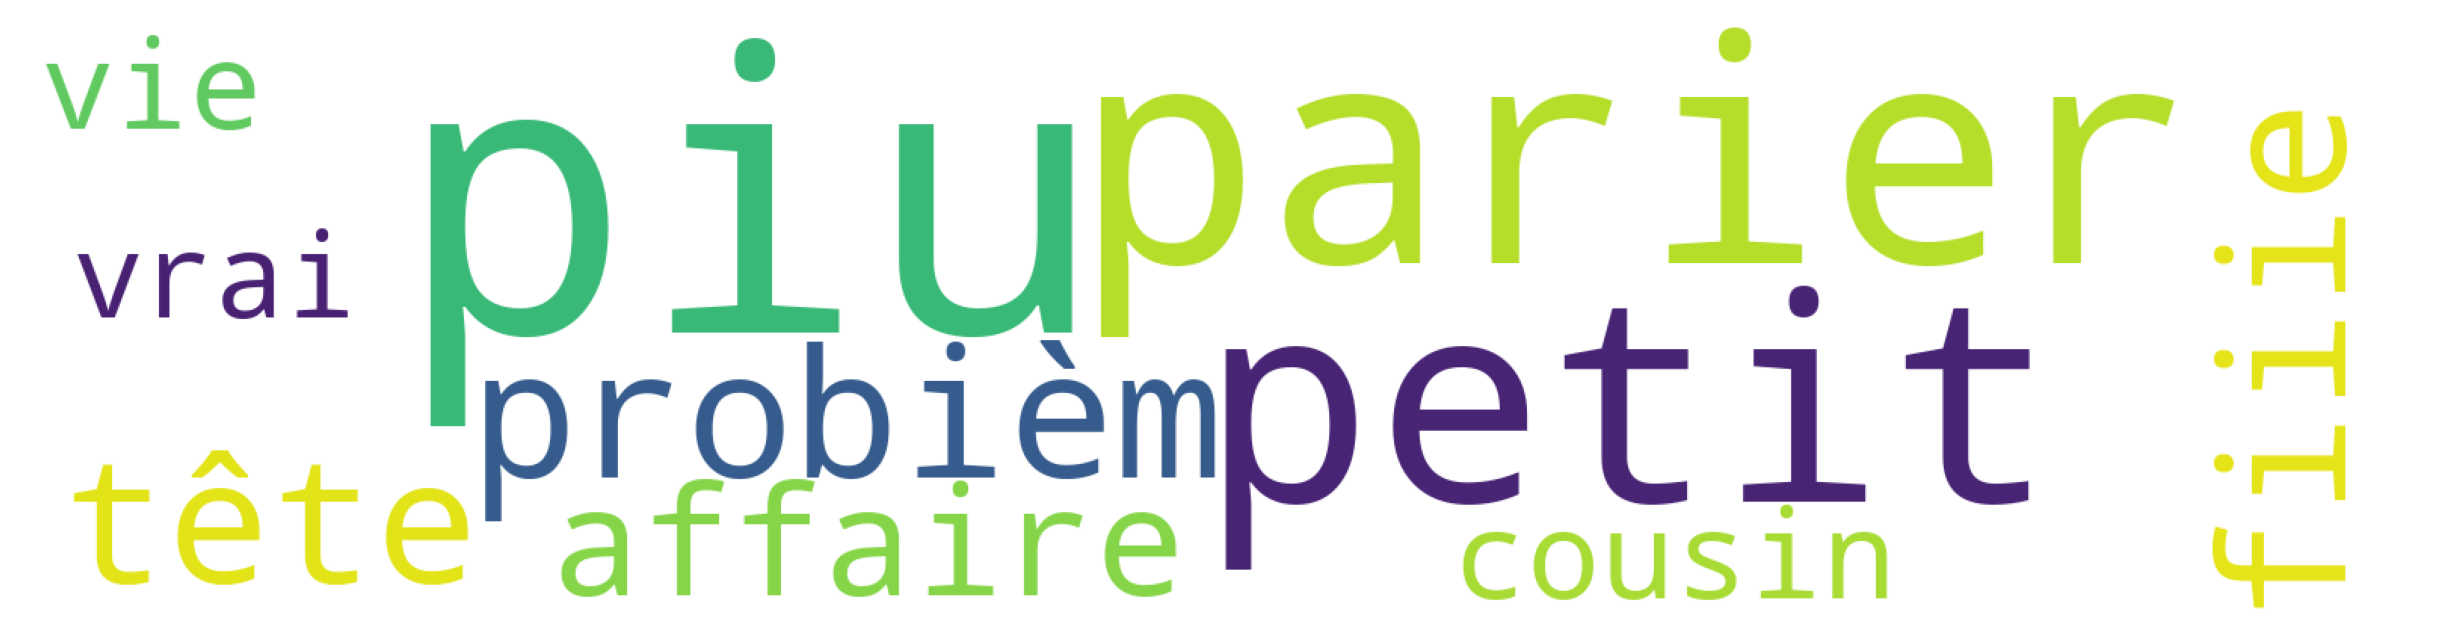

In [407]:
df_words_wc = df_words[df_words["nom_propre"]==0]
#df_words_wc = df_words
docs = df_words_wc["lemma"]
text_wc = " ".join(rev for rev in docs)
plt.figure(figsize=(16, 4),
                       dpi=200)
plt.axis("off")
plt.imshow(
            WordCloud(width=1600,
            height=400,
            max_words = 10,
            background_color="white",stopwords = stop_words).generate(text_wc))
plt.show()

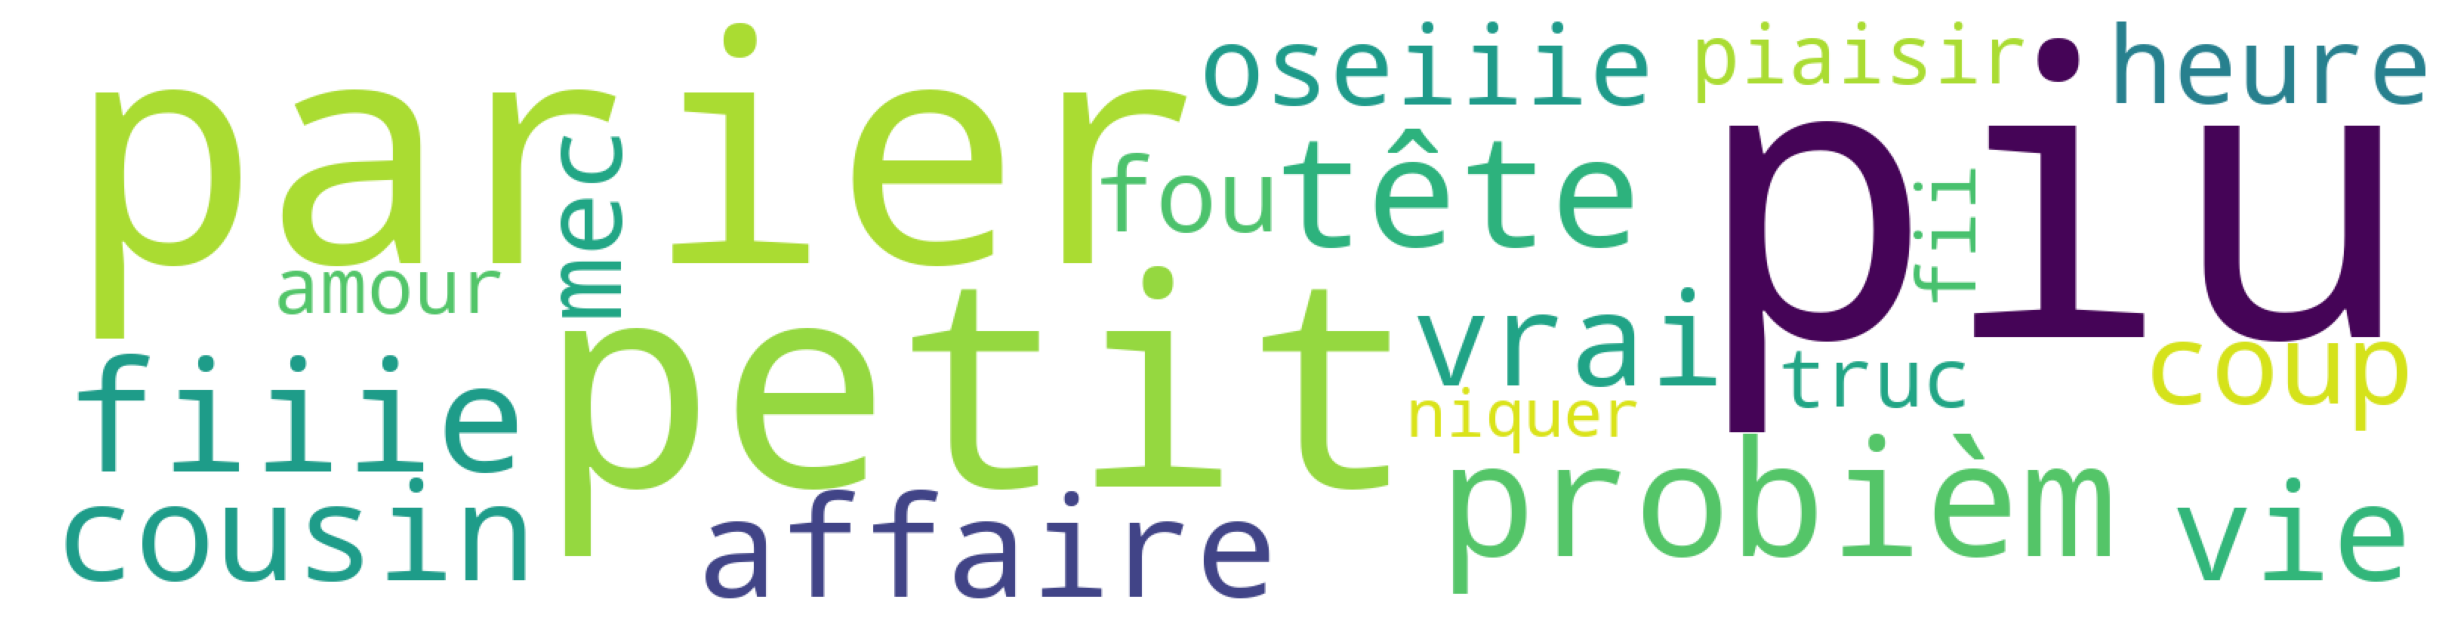

In [408]:
df_words_wc = df_words[df_words["nom_propre"]==0]
#df_words_wc = df_words
docs = df_words_wc["lemma"]
text_wc = " ".join(rev for rev in docs)
plt.figure(figsize=(16, 4),
                       dpi=200)
plt.axis("off")
plt.imshow(
            WordCloud(width=1600,
            height=400,
            max_words = 20,
            background_color="white",stopwords = stop_words).generate(text_wc))
plt.show()

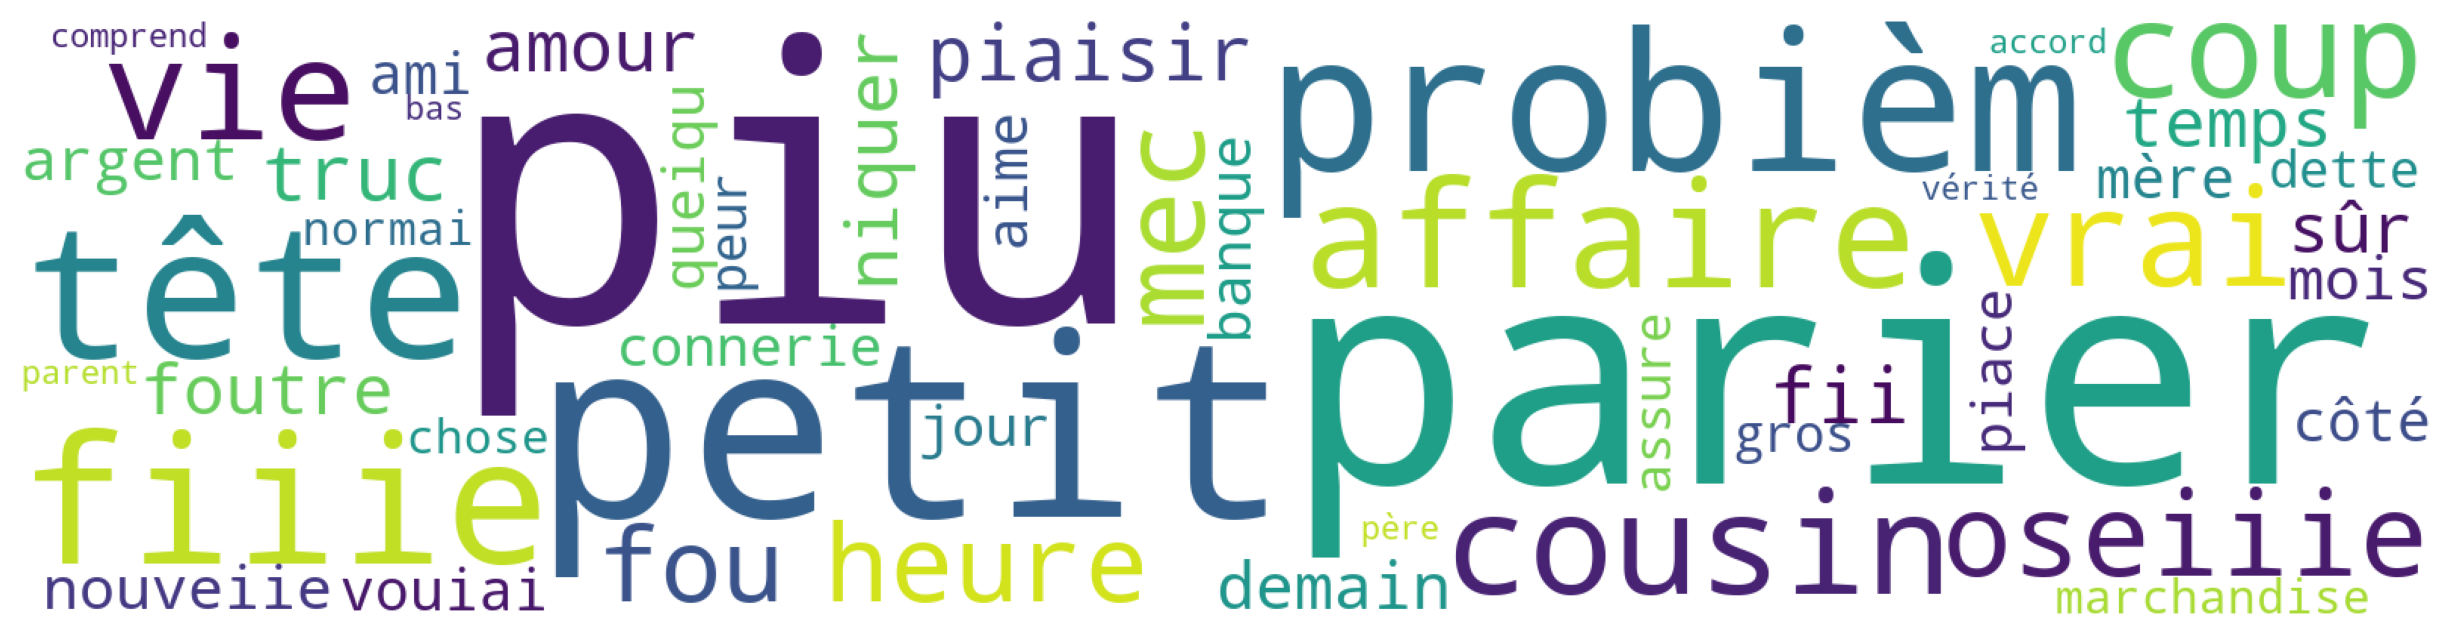

In [409]:
df_words_wc = df_words[df_words["nom_propre"]==0]
#df_words_wc = df_words
docs = df_words_wc["lemma"]
text_wc = " ".join(rev for rev in docs)
plt.figure(figsize=(16, 4),
                       dpi=200)
plt.axis("off")
plt.imshow(
            WordCloud(width=1600,
            height=400,
            max_words = 50,
            background_color="white",stopwords = stop_words).generate(text_wc))
plt.show()

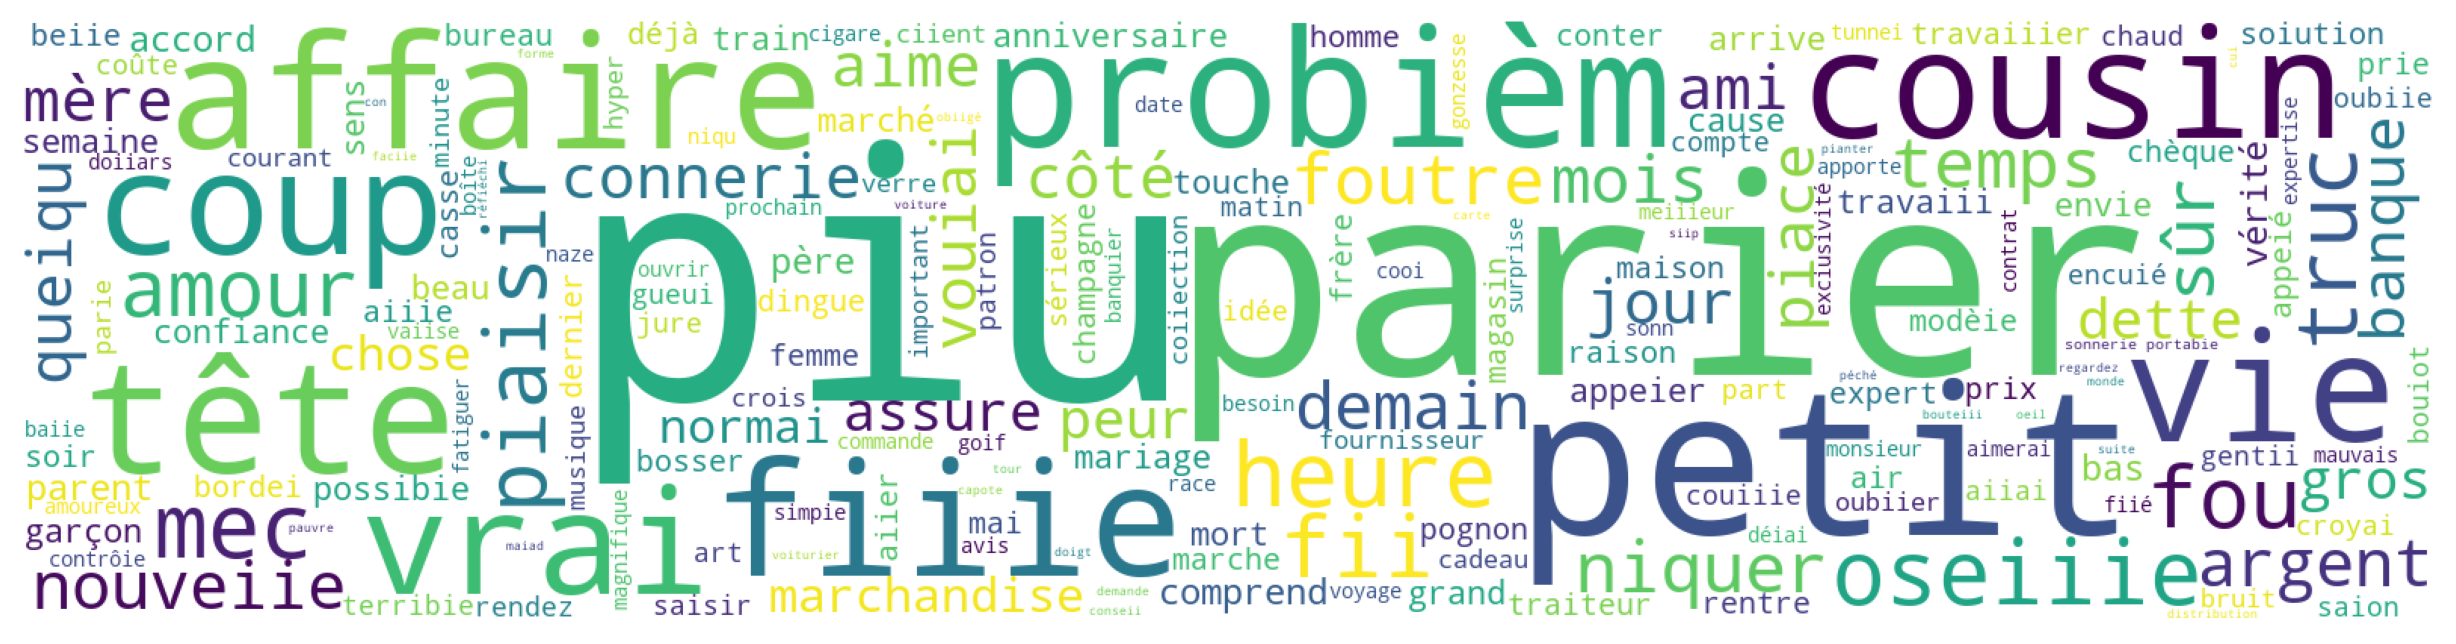

In [410]:
df_words_wc = df_words[df_words["nom_propre"]==0]
#df_words_wc = df_words
docs = df_words_wc["lemma"]
text_wc = " ".join(rev for rev in docs)
plt.figure(figsize=(16, 4),
                       dpi=200)
plt.axis("off")
plt.imshow(
            WordCloud(width=1600,
            height=400,
            background_color="white",stopwords = stop_words).generate(text_wc))
plt.show()

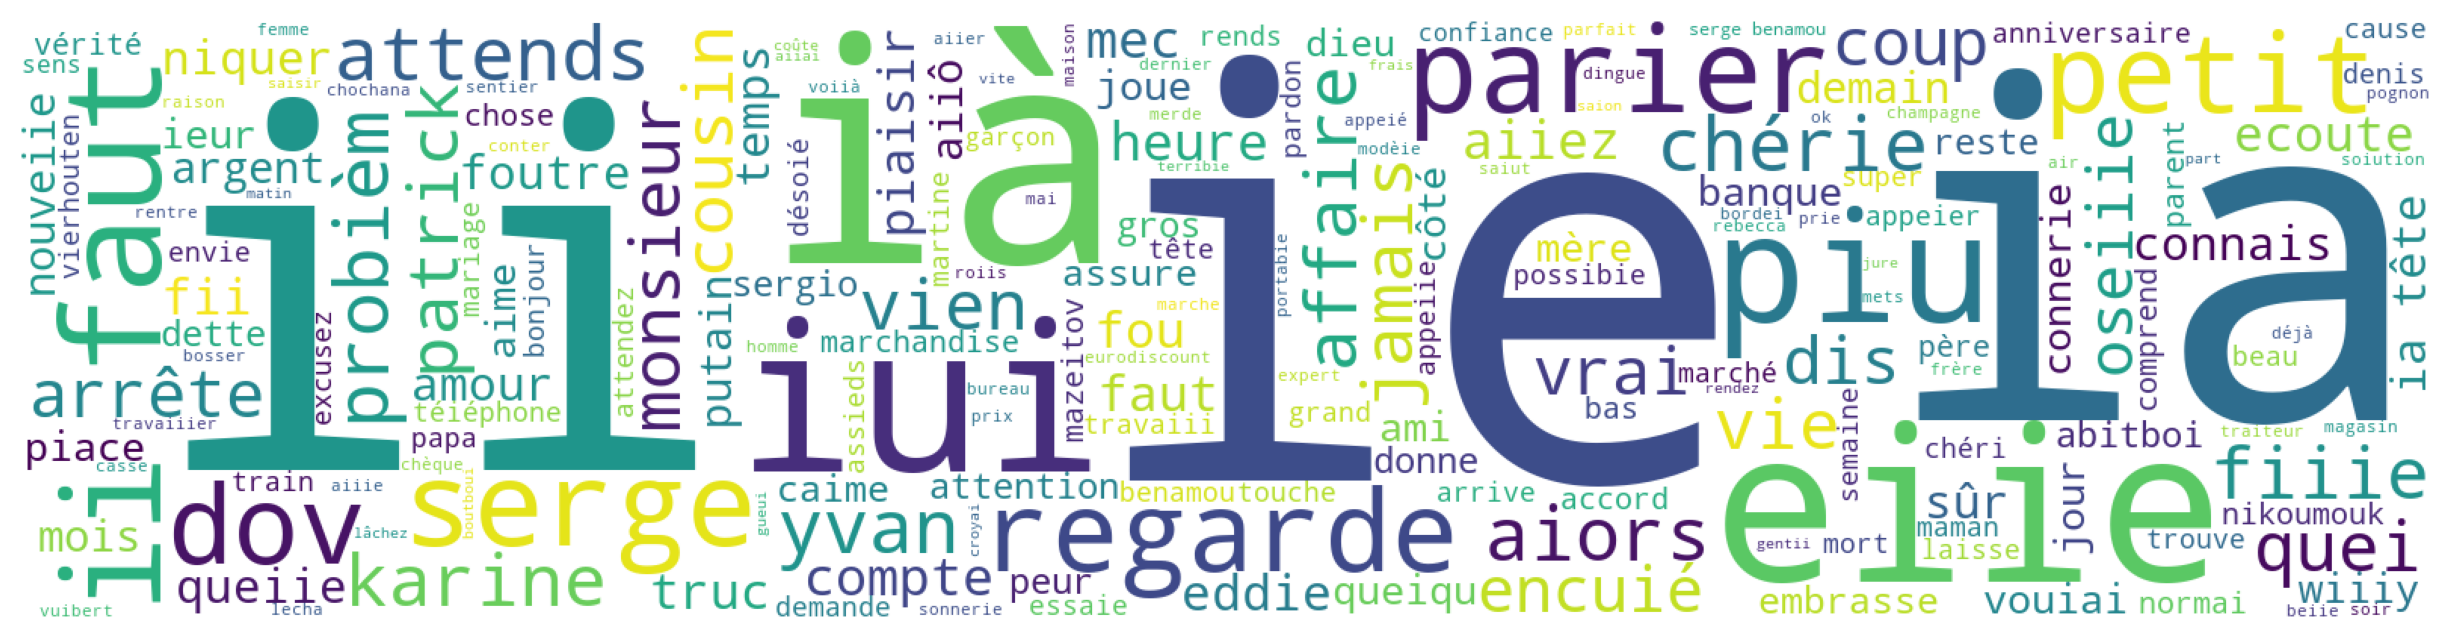

In [411]:
df_words_wc = df_words
docs = df_words_wc["lemma"]
text_wc = " ".join(rev for rev in docs)
plt.figure(figsize=(16, 4),
                       dpi=200)
plt.axis("off")
plt.imshow(
            WordCloud(width=1600,
            height=400,
            background_color="white",stopwords = stop_words).generate(text_wc))
plt.show()